In [12]:
import pandas as pd
import numpy as np
from scipy.stats import zscore

try:
    # Reading the data from a CSV file into a pandas DataFrame
    df_avec_successful = pd.read_csv('../Datasets/movies_cleaned_dataset.csv')
except FileNotFoundError as e:
    print(f"File not found: {e}")
    # Handle the exception (e.g., exit the script or log an error)
    exit()

# Filling missing values for specific columns with their mean
columns_to_fill = ['Inflation_adjusted_profit', 'averageRating', 'Oscar_Wins', 'Nominations']
for column in columns_to_fill:
    df_avec_successful[column].fillna(df_avec_successful[column].mean(), inplace=True)

# Capping extreme values in 'Inflation adjusted profit' to reduce outlier impact
# This reduces the impact of outliers by setting a threshold (90th percentile here)
# Values above this threshold are set to the threshold value itself
cap_threshold = df_avec_successful['Inflation_adjusted_profit'].quantile(0.90)
df_avec_successful['capped_profit'] = df_avec_successful['Inflation_adjusted_profit'].clip(upper=cap_threshold)

# Standardizing selected features (z-score normalization)
z_features = {
    'capped_profit': zscore(df_avec_successful['capped_profit']),
    'averageRating': zscore(df_avec_successful['averageRating']),
    'Oscar_Wins': zscore(df_avec_successful['Oscar_Wins']),
    'Nominations': zscore(df_avec_successful['Nominations'])
}

# Assigning weights to standardized features
weights = {
    'capped_profit': 0.3,
    'averageRating': 0.35,
    'Oscar_Wins': 0.175,
    'Nominations': 0.175
}

# Calculating a composite 'Successful' score using weighted features
df_avec_successful['Successful'] = sum(weights[feature] * z_features[feature] for feature in weights)

# Normalizing the 'Successful' score to a 0-10 scale for interpretability
min_score = df_avec_successful['Successful'].min()
max_score = df_avec_successful['Successful'].max()
df_avec_successful['Successful'] = round((df_avec_successful['Successful'] - min_score) / (max_score - min_score) * 10, 1)

# Sorting the DataFrame by 'Successful' score in descending order
df_avec_successful.sort_values(by='Successful', ascending=False, inplace=True)

# Display the top 300 rows
df_avec_successful.head(300)


,Movie_name,Movie_box_office_revenue,Movie_runtime,Movie_genres,Main_genre,Main_language,Top_genres,Main_country,Main_continent,Plot_summary,...,Estimated_Budget,IMDb,Oscar_Wins,Nominations,Profit,Inflation_adjusted_profit,nconst,Director_name,capped_profit,Successful
11509,Titanic,2185372302,194.0,"{""/m/0fx2s"": ""Tragedy"", ""/m/04xvh5"": ""Costume ...","['Tragedy', 'Costume drama', 'Historical ficti...",Multilingual,Action/Adventure,United States of America,USA,"In 1996, treasure hunter Brock Lovett and his...",...,200000000,tt0120338,11,14,1985372302,2.928104e+09,nm0000116,James Cameron,1.160929e+07,10.0
41728,The Lord of the Rings: The Return of the King,1119929521,250.0,"{""/m/0hj3n2k"": ""Fantasy Adventure"", ""/m/03k9fj...","['Fantasy Adventure', 'Adventure', 'Epic', 'Ac...",Multilingual,Action/Adventure,United States of America,NaN,"Gandalf, Aragorn, Legolas, Gimli, Théoden, Ga...",...,94000000,tt0167260,11,11,1025929521,1.320270e+09,nm0001392,Peter Jackson,1.160929e+07,9.9
12347,Ben-Hur,146900000,219.0,"{""/m/03g3w"": ""History"", ""/m/02l7c8"": ""Romance ...","['History', 'Romance Film', 'Action', 'Drama',...",English Language,Action/Adventure,United States of America,USA,"In AD 26, Judah Ben-Hur is a wealthy prince a...",...,15000000,tt0052618,11,12,131900000,1.071201e+09,nm0943758,William Wyler,1.160929e+07,9.8
13786,West Side Story,43700000,152.0,"{""/m/0lsxr"": ""Crime Fiction"", ""/m/04t36"": ""Mus...","['Crime Fiction', 'Musical', 'Drama', 'Romance...",Multilingual,Family,United States of America,USA,Although the plot summary here is divided into...,...,6000000,tt0055614,10,11,37700000,2.985766e+08,nm0730385,Jerome Robbins,1.160929e+07,9.3
19556,Gone with the Wind,400000000,234.0,"{""/m/060__y"": ""Film adaptation"", ""/m/04xvh5"": ...","['Film adaptation', 'Costume drama', 'Roadshow...",English Language,Drama,United States of America,USA,The film opens on a large cotton plantation c...,...,4000000,tt0031381,8,13,396000000,6.740385e+09,nm0281808,Victor Fleming,1.160929e+07,9.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16366,Speed,350448145,115.0,"{""/m/01jfsb"": ""Thriller"", ""/m/03btsm8"": ""Actio...","['Thriller', 'Action/Adventure', 'Action', 'Cr...",Multilingual,Drama,United States of America,USA,An unidentified man traps several businesspeo...,...,30000000,tt0111257,2,3,320448145,5.118007e+08,nm0000957,Jan de Bont,1.160929e+07,5.9
12229,Star Trek,385494555,126.0,"{""/m/023pxm"": ""Reboot"", ""/m/06n90"": ""Science F...","['Reboot', 'Science Fiction', 'Action', 'Adven...",English Language,Fiction,United States of America,NaN,"In 2233, the Federation starship USS Kelvin i...",...,150000000,tt0796366,1,4,235494555,2.598623e+08,nm0009190,J.J. Abrams,1.160929e+07,5.9
28846,Capote,49233161,98.0,"{""/m/0lsxr"": ""Crime Fiction"", ""/m/017fp"": ""Bio...","['Crime Fiction', 'Biography', 'Crime Drama', ...",English Language,Drama,United States of America,NaN,The film opens in Kansas with the discovery of...,...,7000000,tt0379725,1,5,42233161,5.119582e+07,nm0587955,Bennett Miller,1.160929e+07,5.9
33499,The Help,211608112,145.0,"{""/m/07s9rl0"": ""Drama"", ""/m/04xvlr"": ""Period p...","['Drama', 'Period piece', 'Comedy-drama']",English Language,Drama,United States of America,NaN,Aibileen Clark is a middle-aged black maid wh...,...,25000000,tt1454029,1,4,186608112,1.963948e+08,nm0853238,Tate Taylor,1.160929e+07,5.9


In [13]:
df_avec_successful.describe() 

,Movie_box_office_revenue,Movie_runtime,Release_Date,averageRating,numVotes,Estimated_Budget,Oscar_Wins,Nominations,Profit,Inflation_adjusted_profit,capped_profit,Successful
count,4.215500e+04,3.554400e+04,42155.000000,42155.000000,2.643600e+04,4.215500e+04,42155.000000,42155.000000,4.215500e+04,4.215500e+04,4.215500e+04,42155.00000
mean,9.309064e+06,1.285770e+02,1860.930376,6.268028,2.380605e+04,3.230446e+06,0.031693,0.078947,6.078617e+06,1.160929e+07,9.680834e+05,4.53741
std,5.334529e+07,5.724356e+03,478.466297,0.867840,9.685211e+04,1.477468e+07,0.326571,0.736461,4.449285e+07,8.851471e+07,9.150590e+06,0.33163
min,0.000000e+00,3.000000e-01,0.000000,1.200000,5.000000e+00,0.000000e+00,0.000000,0.000000,-2.250000e+08,-2.739096e+08,-2.739096e+08,0.00000
25%,0.000000e+00,8.600000e+01,1959.000000,6.200000,3.350000e+02,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,4.50000
50%,0.000000e+00,9.600000e+01,1990.000000,6.268028,1.483000e+03,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,4.50000
75%,0.000000e+00,1.100000e+02,2005.000000,6.600000,7.910250e+03,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,4.70000
max,2.782275e+09,1.079281e+06,2014.000000,9.800000,2.816055e+06,3.800000e+08,11.000000,14.000000,2.545275e+09,6.822472e+09,1.160929e+07,10.00000


In [14]:
def get_transformer_feature_names(column_transformer):
    """
    Get feature names from a fitted ColumnTransformer.
    """
    output_features = []

    for name, pipe, features in column_transformer.transformers_:
        if name == 'remainder':
            # If the remainder is a passthrough, its feature names are the same as the column names
            if pipe == 'passthrough':
                output_features.extend(features)
            continue

        # For transformers with a get_feature_names_out method
        if hasattr(pipe, 'get_feature_names_out'):
            transformer_features = pipe.get_feature_names_out(features)
        else:
            transformer_features = features

        output_features.extend(transformer_features)

    return output_features

ML

In [46]:
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
#from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

data = df_avec_successful
X = data.drop('Successful', axis=1)
y = data['Successful']  # target

#preprocessing steps for both categorical and numeric data. Categorical features are filled with a
#placeholder value for any missing data and then one-hot encoded. Numeric features are imputed with their
#mean and then standardized. This transformed data is then used to train the RandomForestRegressor.
#Make sure to adjust the categorical_columns and numeric_columns lists to include all relevant features from your dataset.
#Selecting categorical and numeric columns

categorical_columns = ['Main_language', 'Main_country']  
numeric_columns = ['Movie_runtime']  

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Preprocessing for numerical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())  # standardizing data
])

# Preprocessing for numerical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])
# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_columns)
    ])

# Get a list of unique genres
top_genres = data['Top_genres'].value_counts().index
print(top_genres)
print(data['Top_genres'].value_counts())

#OPTIMISATION

# Hyperparameters grid for Random Forest
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}
# Hyperparameters grid for CatBoost
param_grid_catboost = {
    'classifier__iterations': [100, 500, 1000],
    'classifier__learning_rate': [0.01, 0.1, 0.3],
    'classifier__depth': [4, 6, 10],
}
# Analysis for each genre
for genre in top_genres:
    print("------------------------------------------------------------------------------------------")
    print("------------------------------------------------------------------------------------------")
    print(f"Analyzing genre: {genre} - Data Points: {len(data[data['Top_genres'] == genre])}")

    genre_data = data[data['Top_genres'] == genre]
    # Filter movies with success score greater than 6

    successful_movies = genre_data[genre_data['Successful'] >= 6]
    # Create a copy of the DataFrame to avoid SettingWithCopyWarning
    successful_movies = successful_movies.copy()

    # Perform your operation
    successful_movies['Movie_runtime'] = pd.to_numeric(successful_movies['Movie_runtime'], errors='coerce')

    mean_runtime = successful_movies['Movie_runtime'].dropna().mean()
    print(f"Optimal Runtime: {mean_runtime:.2f} minutes")

    try:
        X_genre = genre_data[categorical_columns]
        y_genre = genre_data['Successful']
        X_train, X_test, y_train, y_test = train_test_split(X_genre, y_genre, test_size=0.1, random_state=42)

        clf = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', CatBoostRegressor(random_state=42, verbose=0))])

        # Grid search for hyperparameter tuning
        grid_search = GridSearchCV(clf, param_grid_catboost, cv=3, scoring='neg_mean_squared_error')
        grid_search.fit(X_train, y_train)

        # Best model after grid search
        best_clf = grid_search.best_estimator_

        # Predict and evaluate
        y_pred = best_clf.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        rmse = mse ** 0.5
        r2 = r2_score(y_test, y_pred)

        print(f"MSE: {mse}, RMSE: {rmse}, R²: {r2}")

        # Feature Importance Analysis
        feature_importances = best_clf.named_steps['classifier'].feature_importances_
        column_transformer = best_clf.named_steps['preprocessor']
        feature_names = get_transformer_feature_names(column_transformer)
       
        # Ensure the number of feature names matches the number of feature importances
        if len(feature_names) == len(feature_importances):
            feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
            sorted_feature_importance = feature_importance_df.sort_values(by='Importance', ascending=False)

            # Extracting and displaying top features excluding 'Main_language_missing'
            top_languages1 = sorted_feature_importance[~sorted_feature_importance['Feature'].str.contains('Main_language_missing')]
            top_languages = top_languages1[top_languages1['Feature'].str.contains('Main_language_')].head(6)
            countries= sorted_feature_importance[sorted_feature_importance['Feature'].str.contains('Main_country_')]
            top_countries = countries[~countries['Feature'].str.contains('missing')].head(5)
            # = sorted_feature_importance[sorted_feature_importance['Feature'].str.contains('Main_country_')].head(4)

            print(f"Top 4 Languages for {genre}:\n{top_languages}")
            print(f"Top 4 Countries for {genre}:\n{top_countries}")
        else:
            print("Number of feature names and feature importances do not match.")

        import plotly.express as px
        import plotly.offline as pyo
        import pandas as pd
        import matplotlib.pyplot as plt
        import seaborn as sns
        import mpld3

        # List of countries to highlight
        def clean_country_name(country_name):
            cleaned_name = country_name.replace("Main_country_", "").replace(" of America", "")
            return cleaned_name

        # Apply the function to each element in the list
        cleaned_countries = [clean_country_name(country) for country in top_countries['Feature']]
        # Generate a unique color for each country
        colors = px.colors.qualitative.Plotly  # This is a list of colors provided by Plotly

        # Ensure there are enough colors for all countries
        assert len(colors) >= len(cleaned_countries), "Not enough colors available."

        # Create a DataFrame
        df = pd.DataFrame({
            'color': cleaned_countries,
            'country': cleaned_countries  # Use country names as color identifiers for now
        })

        # Create a color mapping: each country gets a different color
        color_mapping = {country: colors[i] for i, country in enumerate(cleaned_countries)}

        # Create the interactive world map
        fig = px.choropleth(df,
                            locations='color',
                            locationmode='country names',
                            color='country',
                            hover_name='color',
                            color_discrete_map=color_mapping,  # Use the color mapping
                            title='Top 5 recommended release country')

        # Show the figure
        fig.show()
        # Save the figure to an HTML file
        if genre == 'Action/Adventure':
            pyo.plot(fig, filename=f'catboost_info/mapactionadventure.html', auto_open=False)
        else:
            pyo.plot(fig, filename=f'catboost_info/map_{genre}.html', auto_open=False)

        # Create a beautiful bar plot    
        # Create a bar plot using Plotly Express
        
        top_languages['Feature'] = top_languages['Feature'].str.replace('Main_language_', '')
        top_languages['Feature'] = top_languages['Feature'].str.replace('Language', '')

        fig2 = px.bar(top_languages.head(5),
                    x='Importance', 
                    y='Feature',
                    title='Top 5 Important Language',
                    labels={'Importance': 'Language Importance', 'Feature': 'Languages'},
                    orientation='h',  # Horizontal bar plot
                    color='Importance',  # Color the bars by the 'Importance' value
                    color_continuous_scale='viridis')  # Use the 'viridis' color scale

        # Update layout for better readability
        fig2.update_layout(
            xaxis_title='Language Importance',
            yaxis_title='Languages',
            title_font_size=15,
            xaxis_tickangle=45
        )

        # Show the plot
        fig2.show()

        if genre == 'Action/Adventure':
            pyo.plot(fig2, filename=f'catboost_info/maplangueactionadventure.html', auto_open=False)


        else:
            pyo.plot(fig2, filename=f'catboost_info/maplangue_{genre}.html', auto_open=False)

    except Exception as e:
        print(f"An error occurred while analyzing genre {genre}: {e}")

Index(['Drama', 'Other', 'Family', 'Action/Adventure', 'Horror', 'Fiction'], dtype='object', name='Top_genres')
Top_genres
Drama               16115
Other               13334
Family               6265
Action/Adventure     3544
Horror               1554
Fiction              1343
Name: count, dtype: int64
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
Analyzing genre: Drama - Data Points: 16115
Optimal Runtime: 134.95 minutes
MSE: 0.14296481470156197, RMSE: 0.378106882642411, R²: 0.034469731152307004
Top 4 Languages for Drama:
                             Feature  Importance
46        Main_language_Multilingual   50.494923
28      Main_language_Hindi Language    3.042442
20    Main_language_English Language    2.993256
35   Main_language_Japanese Language    1.601940
64   Main_language_Standard Mandarin    1.450680
42  Main_language_Malayalam Language    

------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
Analyzing genre: Other - Data Points: 13334
Optimal Runtime: 110.25 minutes
MSE: 0.0413102613298027, RMSE: 0.20324925911255542, R²: 0.010826326856100521
Top 4 Languages for Other:
                             Feature  Importance
36      Main_language_Hindi Language   13.890588
43    Main_language_Kannada Language    8.060903
50  Main_language_Malayalam Language    4.008465
23    Main_language_English Language    3.558457
67         Main_language_Silent film    3.387623
54        Main_language_Multilingual    2.441544
Top 4 Countries for Other:
                                    Feature  Importance
195  Main_country_ United States of America    6.130284
194            Main_country_ United Kingdom    6.079103
142                     Main_country_ Italy    3.622569
136                     Main_country_ India 

------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
Analyzing genre: Family - Data Points: 6265
Optimal Runtime: 120.80 minutes
MSE: 0.14802529670511808, RMSE: 0.3847405576555688, R²: -0.015524673193787475
Top 4 Languages for Family:
                             Feature  Importance
31        Main_language_Multilingual   39.723354
12    Main_language_English Language    7.460766
19      Main_language_Hindi Language    6.748765
28      Main_language_Malay Language    0.848026
29  Main_language_Malayalam Language    0.822143
24   Main_language_Japanese Language    0.793302
Top 4 Countries for Family:
                                    Feature  Importance
124  Main_country_ United States of America   22.026408
79                     Main_country_ France    1.490150
68                     Main_country_ Canada    1.128523
91                      Main_country_ Ita

------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
Analyzing genre: Action/Adventure - Data Points: 3544
Optimal Runtime: 147.46 minutes
MSE: 0.1498495263081949, RMSE: 0.38710402517694764, R²: 0.02932631591171042
Top 4 Languages for Action/Adventure:
                            Feature  Importance
24       Main_language_Multilingual   41.886105
6    Main_language_English Language    3.983837
11     Main_language_Hindi Language    1.964439
16  Main_language_Japanese Language    1.176042
39    Main_language_Telugu language    0.855676
17   Main_language_Kannada Language    0.334573
Top 4 Countries for Action/Adventure:
                                   Feature  Importance
98  Main_country_ United States of America   25.783293
67                     Main_country_ India    8.986391
70                     Main_country_ Italy    4.333649
48                    Ma

------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
Analyzing genre: Horror - Data Points: 1554
Optimal Runtime: 119.50 minutes
MSE: 0.05640411103602283, RMSE: 0.23749549687525198, R²: 0.018153797720612763
Top 4 Languages for Horror:
                            Feature  Importance
18       Main_language_Multilingual   18.136203
6    Main_language_English Language    8.863733
24   Main_language_Spanish Language    5.783156
1           Main_language_Cantonese    2.683161
28     Main_language_Tamil Language    1.936882
13  Main_language_Japanese Language    1.416419
Top 4 Countries for Horror:
                                   Feature  Importance
52                    Main_country_ Mexico   10.579068
68  Main_country_ United States of America   10.053723
35                    Main_country_ Canada    6.627725
50                     Main_country_ Japan    2.8513

------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
Analyzing genre: Fiction - Data Points: 1343
Optimal Runtime: 118.00 minutes
MSE: 0.13055572595593345, RMSE: 0.3613249589440694, R²: 0.025986710025590165
Top 4 Languages for Fiction:
                            Feature  Importance
5    Main_language_English Language   28.772547
15       Main_language_Multilingual   25.136864
12  Main_language_Japanese Language    4.305480
10   Main_language_Italian Language    0.715775
17   Main_language_Russian Language    0.697196
9      Main_language_Hindi Language    0.346679
Top 4 Countries for Fiction:
                                   Feature  Importance
42                     Main_country_ Japan    8.869222
59  Main_country_ United States of America    5.619712
44                    Main_country_ Mexico    4.469529
53                     Main_country_ Spain    4.21

cast : find best profile for each of the top 4 roles (sex, number of movies played in, age)
In the code below we trained XGB(boosted trees) model such that it can predicts success rate based on thses features 

Analyzing genre: Drama - Data Points: 10812
Optimized XGBoost MSE: 0.23903633476251737, R²: -0.001251679272758155
role_1 Profile:
              Feature  Importance
4  role_1_roles_count    0.091079
0          role_1_age    0.078715
8          role_1_sex    0.046302

role_2 Profile:
              Feature  Importance
5  role_2_roles_count    0.092299
1          role_2_age    0.089022
9          role_2_sex    0.069094

role_3 Profile:
               Feature  Importance
6   role_3_roles_count    0.132370
2           role_3_age    0.084993
10          role_3_sex    0.067571

role_4 Profile:
               Feature  Importance
7   role_4_roles_count    0.125357
3           role_4_age    0.098003
11          role_4_sex    0.025194

Optimized Profile: {'role_1': {'age': 65, 'roles_count': 69, 'sex': 'M'}, 'role_2': {'age': 74, 'roles_count': 115, 'sex': 'M'}, 'role_3': {'age': 87, 'roles_count': 30, 'sex': 'M'}, 'role_4': {'age': 19, 'roles_count': 106, 'sex': 'M'}}
Best Actors: {'role_1': ['To

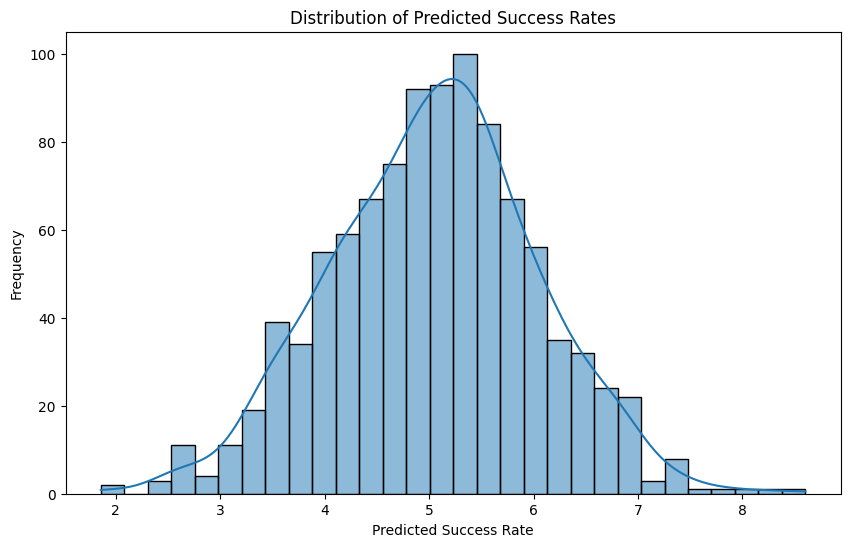

Analyzing genre: Other - Data Points: 4174
Optimized XGBoost MSE: 0.08851355714485308, R²: 0.007844333826460548
role_1 Profile:
              Feature  Importance
4  role_1_roles_count    0.113624
0          role_1_age    0.099826
8          role_1_sex    0.071684

role_2 Profile:
              Feature  Importance
5  role_2_roles_count    0.098836
1          role_2_age    0.086622
9          role_2_sex    0.069630

role_3 Profile:
               Feature  Importance
6   role_3_roles_count    0.097961
2           role_3_age    0.071416
10          role_3_sex    0.036547

role_4 Profile:
               Feature  Importance
7   role_4_roles_count    0.100915
3           role_4_age    0.084225
11          role_4_sex    0.068712

Optimized Profile: {'role_1': {'age': 68, 'roles_count': 142, 'sex': 'M'}, 'role_2': {'age': 37, 'roles_count': 60, 'sex': 'M'}, 'role_3': {'age': 49, 'roles_count': 23, 'sex': 'M'}, 'role_4': {'age': 46, 'roles_count': 39, 'sex': 'M'}}
Best Actors: {'role_1': ['Chris

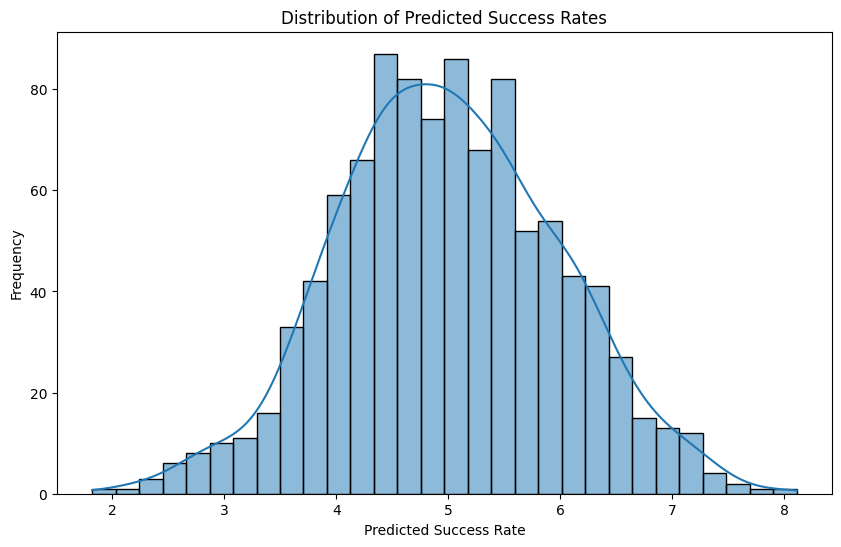

Analyzing genre: Family - Data Points: 4033
Optimized XGBoost MSE: 0.21721703915522397, R²: 0.0014247006258474304
role_1 Profile:
              Feature  Importance
4  role_1_roles_count    0.093531
8          role_1_sex    0.063572
0          role_1_age    0.046780

role_2 Profile:
              Feature  Importance
5  role_2_roles_count    0.080512
1          role_2_age    0.065948
9          role_2_sex    0.054239

role_3 Profile:
               Feature  Importance
6   role_3_roles_count    0.180280
2           role_3_age    0.123154
10          role_3_sex    0.000000

role_4 Profile:
               Feature  Importance
7   role_4_roles_count    0.118182
3           role_4_age    0.100195
11          role_4_sex    0.073607

Optimized Profile: {'role_1': {'age': 67, 'roles_count': 108, 'sex': 'F'}, 'role_2': {'age': 18, 'roles_count': 109, 'sex': 'F'}, 'role_3': {'age': 65, 'roles_count': 48, 'sex': 'M'}, 'role_4': {'age': 50, 'roles_count': 20, 'sex': 'M'}}
Best Actors: {'role_1': ['Mi

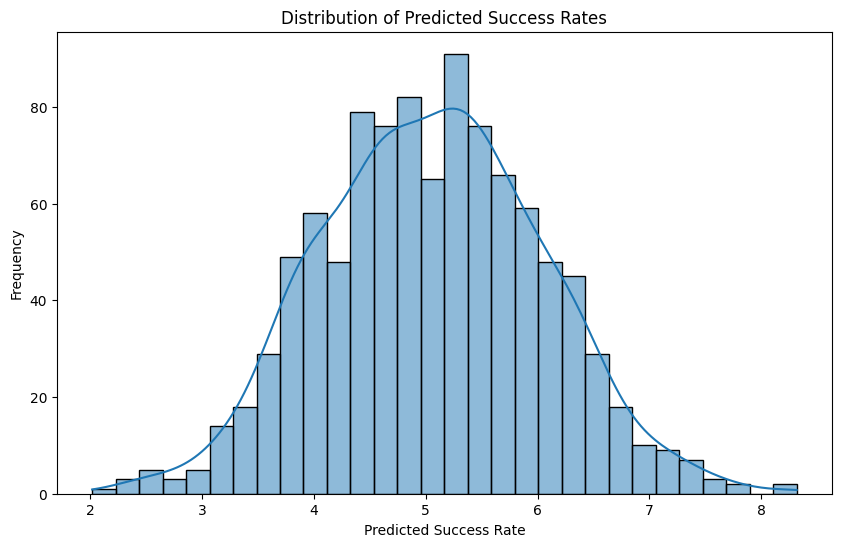

Analyzing genre: Action/Adventure - Data Points: 2270
Optimized XGBoost MSE: 0.25025530896626375, R²: -0.016594841243181557
role_1 Profile:
              Feature  Importance
4  role_1_roles_count    0.094232
0          role_1_age    0.088282
8          role_1_sex    0.045496

role_2 Profile:
              Feature  Importance
1          role_2_age    0.101958
5  role_2_roles_count    0.084788
9          role_2_sex    0.000000

role_3 Profile:
               Feature  Importance
2           role_3_age    0.146662
10          role_3_sex    0.137488
6   role_3_roles_count    0.079947

role_4 Profile:
               Feature  Importance
7   role_4_roles_count    0.092524
11          role_4_sex    0.072890
3           role_4_age    0.055734

Optimized Profile: {'role_1': {'age': 36, 'roles_count': 63, 'sex': 'F'}, 'role_2': {'age': 45, 'roles_count': 23, 'sex': 'M'}, 'role_3': {'age': 13, 'roles_count': 32, 'sex': 'F'}, 'role_4': {'age': 39, 'roles_count': 27, 'sex': 'F'}}
Best Actors: {'role_

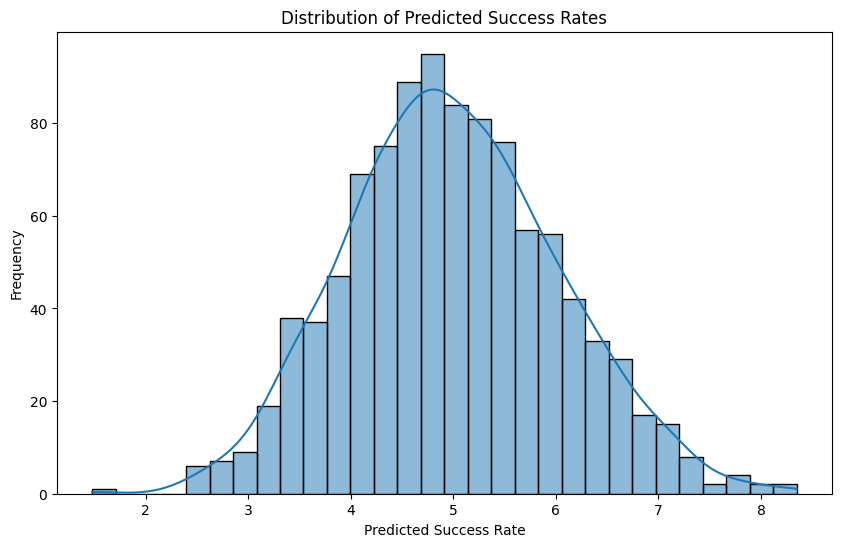

Analyzing genre: Horror - Data Points: 846
Optimized XGBoost MSE: 0.14489901190627819, R²: 0.030865874848859387
role_1 Profile:
              Feature  Importance
0          role_1_age    0.128715
8          role_1_sex    0.063913
4  role_1_roles_count    0.052354

role_2 Profile:
              Feature  Importance
5  role_2_roles_count    0.083463
9          role_2_sex    0.069684
1          role_2_age    0.046523

role_3 Profile:
               Feature  Importance
10          role_3_sex    0.211960
2           role_3_age    0.099327
6   role_3_roles_count    0.080418

role_4 Profile:
               Feature  Importance
7   role_4_roles_count    0.067317
3           role_4_age    0.067303
11          role_4_sex    0.029023

Optimized Profile: {'role_1': {'age': 11, 'roles_count': 74, 'sex': 'M'}, 'role_2': {'age': 76, 'roles_count': 114, 'sex': 'M'}, 'role_3': {'age': 54, 'roles_count': 140, 'sex': 'M'}, 'role_4': {'age': 73, 'roles_count': 138, 'sex': 'F'}}
Best Actors: {'role_1': ['Hri

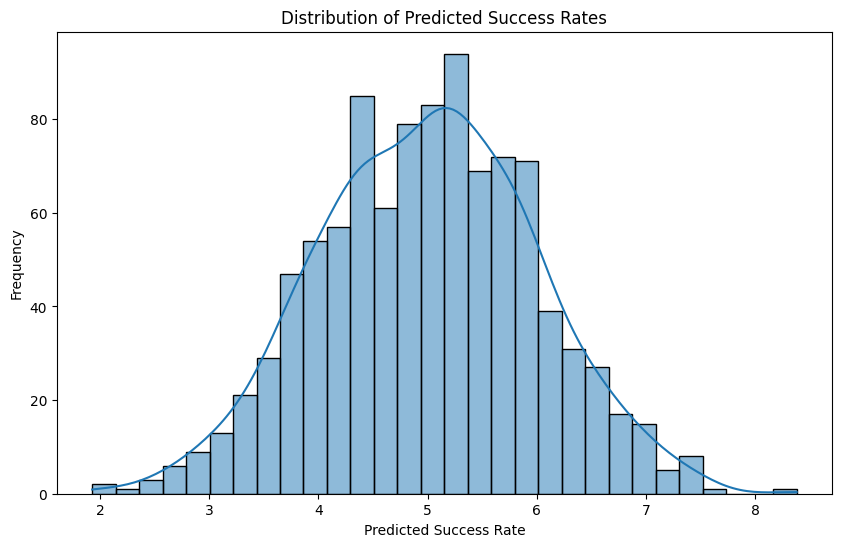

Analyzing genre: Fiction - Data Points: 788
Optimized XGBoost MSE: 0.26452005589676475, R²: -0.05428442316407733
role_1 Profile:
              Feature  Importance
4  role_1_roles_count    0.115761
0          role_1_age    0.101466
8          role_1_sex    0.032266

role_2 Profile:
              Feature  Importance
5  role_2_roles_count    0.103524
1          role_2_age    0.096743
9          role_2_sex    0.000000

role_3 Profile:
               Feature  Importance
2           role_3_age    0.105652
6   role_3_roles_count    0.096334
10          role_3_sex    0.067398

role_4 Profile:
               Feature  Importance
7   role_4_roles_count    0.109735
3           role_4_age    0.101167
11          role_4_sex    0.069952

Optimized Profile: {'role_1': {'age': 37, 'roles_count': 87, 'sex': 'F'}, 'role_2': {'age': 83, 'roles_count': 114, 'sex': 'F'}, 'role_3': {'age': 72, 'roles_count': 87, 'sex': 'M'}, 'role_4': {'age': 82, 'roles_count': 71, 'sex': 'F'}}
Best Actors: {'role_1': ['Avit

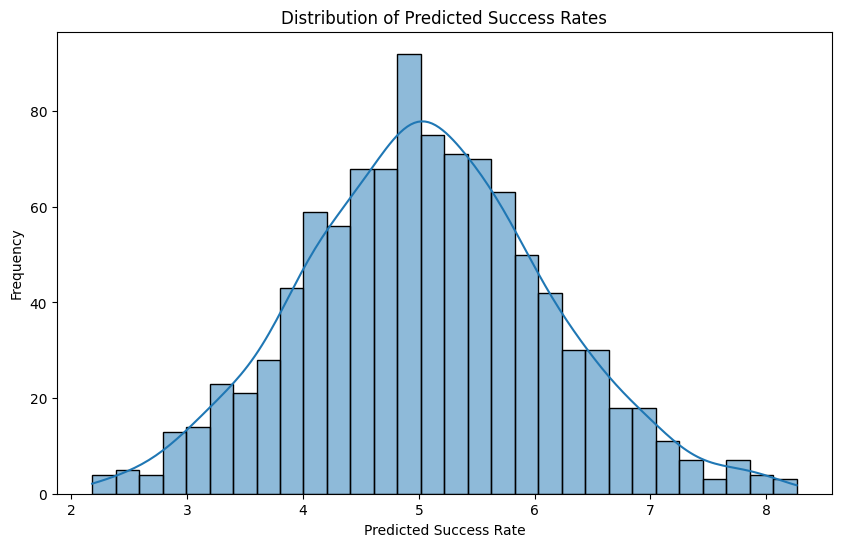

{}


In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import numpy as np
import random

pd.options.mode.chained_assignment = None  # default='warn'

def load_data(filepath):
    """
    Load dataset from a specified filepath.
    """
    try:
        df = pd.read_csv(filepath)
        return df
    except FileNotFoundError:
        print(f"File not found: {filepath}")
        return None

def preprocess_data(df,genre):
    """
    Preprocess the dataset: drop missing values, filter by 'Successful' column,
    calculate actors' ages, and encode categorical data. Only keep a specified Genre.
    """
    df.dropna(inplace=True)
    df = df[df['Top_genres'] == genre]

    #df = df[df['Successful'] >= 7.5]

    df['Release_Date'] = pd.to_datetime(df['Release_Date'], format='%Y')


    # Ensure that birth year columns are numeric
    for role in ['role_1', 'role_2', 'role_3', 'role_4']:
        birth_year_column = f'{role}_birth_year'
        df[birth_year_column] = pd.to_numeric(df[birth_year_column], errors='coerce')
        #we use pd.to_numeric with errors='coerce' to convert the birth year columns to numeric types

    # Calculating ages of actors from their birth year and movie release year
    df['role_1_age'] = df['Release_Date'].dt.year - df['role_1_birth_year']
    df['role_2_age'] = df['Release_Date'].dt.year - df['role_2_birth_year']
    df['role_3_age'] = df['Release_Date'].dt.year - df['role_3_birth_year']
    df['role_4_age'] = df['Release_Date'].dt.year - df['role_4_birth_year']

    df['role_1_roles_count'] =  df['role_1_roles_count'] / df['role_1_age']
    df['role_2_roles_count'] =  df['role_1_roles_count'] / df['role_2_age']
    df['role_3_roles_count'] =  df['role_1_roles_count'] / df['role_3_age']
    df['role_4_roles_count'] =  df['role_1_roles_count'] / df['role_4_age']

    # Encoding categorical data
    label_encoder = LabelEncoder()
    for role in ['role_1_sex', 'role_2_sex', 'role_3_sex', 'role_4_sex']:
        df[role] = label_encoder.fit_transform(df[role].astype(str))

    return df


def feature_selection(df):
    """
    Select and return features and target variable from the dataframe.
    """
    features = df[['role_1_age', 'role_2_age', 'role_3_age', 'role_4_age',
                   'role_1_roles_count', 'role_2_roles_count', 
                   'role_3_roles_count', 'role_4_roles_count',
                   'role_1_sex', 'role_2_sex', 'role_3_sex', 'role_4_sex']]
    target = df['Successful']

    # Align features and target by index to ensure they match
    features.dropna(inplace=True)
    target = target.loc[features.index]

    return features, target

def train_model(X_train, y_train):
    """
    Train the model using GridSearchCV with XGBoost.
    """
    param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 2, 3],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.1, 0.2]
    }
    param_grid2 = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 4, 5],
        'min_child_weight': [1, 2, 3],
        'subsample': [0.7, 0.8, 0.9]
    }

    xgb = XGBRegressor(random_state=42)
    grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid2, 
                           cv=3, n_jobs=-1, verbose=0, 
                           scoring='neg_mean_squared_error')
    grid_search.fit(X_train_scaled, y_train)

    return grid_search.best_estimator_

def evaluate_model(model, X_test, y_test):
    """
    Evaluate the model on the test set and return the MSE and R² score.
    """
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, r2

def feature_importance(model, features):
    """
    Generate a DataFrame of feature importances.
    """
    feature_importances = model.feature_importances_
    importance_df = pd.DataFrame({'Feature': features.columns, 'Importance': feature_importances})
    return importance_df.sort_values(by='Importance', ascending=False)

########################################################################################################################
#Purpose of the random search algorithm below is to find best combination of feature that maximisze success rate based on the importance of the parameters find above

def convert_profile_to_model_input(profile):
    # Convert the profile dictionary to a list or array in the order expected by the model
    # This function needs to be defined based on how your model expects the input
    # For example:
    model_input = []
    for role, features in profile.items():
        model_input.append(features['age'])
        model_input.append(features['roles_count'])
        model_input.append(1 if features['sex'] == 'M' else 0)  # Assuming sex is binary and encoded as 1/0
    return model_input

def optimize_profiles(model, initial_guess, iterations=1000):
    """
    Optimizes actor profiles to achieve the best success rate predicted by the model.
    
    Args:
    model: Trained machine learning model used for prediction.
    initial_guess: Initial guess of the profiles.
    iterations: Number of iterations for the optimization process.
    
    Returns:
    Tuple of the best profile and its corresponding success rate.
    """
    best_profile = initial_guess.copy()
    best_score = -np.inf

    for _ in range(iterations):
        current_profile = best_profile.copy()

        # Randomly adjust one parameter in one of the roles
        role_to_adjust = random.choice(list(current_profile.keys()))
        feature_to_adjust = random.choice(list(current_profile[role_to_adjust].keys()))

        if feature_to_adjust == 'age':
            current_profile[role_to_adjust]['age'] = random.choice(age_range)
        elif feature_to_adjust == 'roles_count':
            current_profile[role_to_adjust]['roles_count'] = random.choice(role_count_range)
        elif feature_to_adjust == 'sex':
            current_profile[role_to_adjust]['sex'] = random.choice(sex_range)

        # Convert the current profile for model input and predict success rate
        model_input = convert_profile_to_model_input(current_profile)
        success_rate = model.predict([model_input])[0]

        # Update best profile if current is better
        if success_rate > best_score:
            best_score = success_rate
            best_profile = current_profile

    return best_profile, best_score

########################################################################################################################
def similarity_score(actor_data, target_profile):
    age_diff = abs(actor_data['age'] - target_profile['age'])
    roles_count_diff = abs(actor_data['total_roles'] - target_profile['roles_count'])
    sex_match = actor_data['category'] == target_profile['sex']
    return age_diff * 0.5 + roles_count_diff * 0.5 + (0 if sex_match else 1000)


def find_best_matches(df, optimized_profile):
    """
    Finds the top 2 best matching actors for the given optimized profile.
    
    Args:
    df: DataFrame containing actor information.
    optimized_profile: Dictionary of the optimized profiles.
    
    Returns:
    Dictionary of top 2 best matching actors for each role.
    """
    top2_matches = {}
    for role, profile in optimized_profile.items():
        # Calculate similarity score for each actor in the dataframe
        df['similarity_score'] = df.apply(lambda row: similarity_score(row, profile), axis=1)
        
        # Sort the dataframe by similarity score and select the top 2 actors
        top2 = df.sort_values(by='similarity_score').head(2)
        
        # Store the names of the top 2 actors for each role
        top2_matches[role] = top2['name'].tolist()

    return top2_matches


def get_actor_names(nconst_lists, cast_df):
    """
    Retrieves actor names corresponding to the nconst values for each role. 
    If the primary choice (first nconst) leads to an IndexError, it tries the secondary choice, and so on.
    
    Args:
    nconst_lists: Dictionary of lists of nconst values for actors for each role.
    cast_df: DataFrame containing cast names and nconst.
    
    Returns:
    Dictionary of actor names for each role.
    """
    primary_names = {role: cast_name_df.loc[cast_name_df['nconst'] == actor_id, 'primaryName'].values[0] 
                 for role, actor_id in similar_actors.items() if cast_name_df['nconst'].str.contains(actor_id).any()}
    
    return primary_names


# Main execution
if __name__ == "__main__":
    filepath = '../Datasets/cast_processed_corrected_genres.csv'
    df = load_data(filepath)
    Result = {}

    if df is not None:
        Top_Genre =['Drama','Other','Family', 'Action/Adventure', 'Horror', 'Fiction']
        for genre in Top_Genre:
            print(f"Analyzing genre: {genre} - Data Points: {len(df[df['Top_genres'] == genre])}")

            ######ﬁ#############################################################################################################
            ######ﬁ###################### XGB to understand importance of each features ########################################
            ######ﬁ#############################################################################################################
            
            df_processed = preprocess_data(df,genre)
            features, target = feature_selection(df_processed)

            # Splitting the dataset
            X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
            X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
            X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

            # You can fill NaN values with the mean (or any other appropriate value)
            X_train.fillna(X_train.mean(), inplace=True)
            X_test.fillna(X_test.mean(), inplace=True)

            # Feature scaling
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)

            # Model training
            best_model = train_model(X_train_scaled, y_train)

            # Model evaluation
            mse_best, r2_best = evaluate_model(best_model, X_test_scaled, y_test)
            print(f"Optimized XGBoost MSE: {mse_best}, R²: {r2_best}")

            # Feature importance
            importance_df = feature_importance(best_model, features)

            # Print out the result
            roles = ['role_1', 'role_2', 'role_3', 'role_4']
            profiles = {}

            for role in roles:
                role_features = importance_df[importance_df['Feature'].str.startswith(role)]
                profiles[role] = role_features.sort_values(by='Importance', ascending=False)

            for role, profile in profiles.items():
                print(f"{role} Profile:")
                print(profile)
                print()

            ######ﬁ#############################################################################################################
            ######ﬁ################ find best combination of feature that maximisze success rate ###############################
            ######ﬁ#############################################################################################################

            #Purpose of the random search algorithm below is to find best combination of feature that maximisze success
            #rate based on the importance of the parameters found

            # Define the range of values and initial guesses
            age_range = range(10, 90)  # Age from 10 to 90
            role_count_range = range(1, 150)  # Role count from 1 to 150
            sex_range = ['M', 'F']  # Male and Female

            initial_guess = {
                'role_1': {'age': 0, 'roles_count': 0, 'sex': 'M'},
                'role_2': {'age': 0, 'roles_count': 0, 'sex': 'M'},
                'role_3': {'age': 0, 'roles_count': 0, 'sex': 'M'},
                'role_4': {'age': 0, 'roles_count': 0, 'sex': 'M'}
            }
            
            # Finding similar actors for each role
            optimized_profile, optimized_score = optimize_profiles(best_model, initial_guess, iterations=50000)
            print("Optimized Profile:", optimized_profile)
            
            ####################################################################################################################
            ##################### Looking for the best match in the database in order to find Actors ###########################
            ####################################################################################################################

            try:
                cast_name_df = pd.read_csv('../Datasets/actors_alive.csv')
                similar_actors = find_best_matches(cast_name_df, optimized_profile)
                print("Best Actors:", similar_actors)

            except FileNotFoundError as e:
                print(f"File not found: {e}")


            # Plotting Feature Importance
            top_features = importance_df.head(16)

            # Creating the bar plot with Plotly Express
            fig3 = px.bar(top_features,
              x='Importance', 
              y='Feature',
              title='Important Features for Movie Success : Actors',
              labels={'Importance': 'Feature Importance', 'Feature': 'Features'},
              orientation='h',  # Horizontal bar plot
              color='Importance',  # Color the bars by the 'Importance' value
              color_continuous_scale='viridis')  # Color scale for the bars

            # Displaying the plot
            fig3.show()

            if genre == 'Action/Adventure':
                pyo.plot(fig3, filename=f'catboost_info/featureimportance_actionadventure.html', auto_open=False)
            else:
                pyo.plot(fig3, filename=f'catboost_info/featureimportance_{genre}.html', auto_open=False)

        print(Result)

Analysis

Director : Find best profil based on the number of movies and the Director age 

In [44]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import warnings
import plotly.express as px
warnings.filterwarnings("ignore")

# ... [Include the previously defined functions: read_data, preprocess_data, train_model, evaluate_model, find_optimal_combination] ...

# Load the data
movies_df = read_data('../Datasets/movies_directors_with_genre.csv')
if movies_df is None:
    raise Exception("Data file not found. Please check the file path.")

# Define genres to analyze
genres = ['Drama', 'Family', 'Action/Adventure', 'Horror', 'Fiction']

# Initialize a dictionary to store results
optimal_directors_by_genre = {}

# Initialize dictionaries for feature importances and optimal combinations
feature_importances_by_genre = {}
optimal_combinations = {}

for genre in genres:
    df_genre = preprocess_data(movies_df, genre)
    X = df_genre[['num_movies', 'Director_age']]
    y = df_genre['Successful']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    best_model = train_model(X_train, y_train)
    evaluate_model(best_model, X_test, y_test)
    
    best_combination = find_optimal_combination(best_model)
    optimal_combinations[genre] = best_combination

    # Store feature importances
    feature_importances = best_model.feature_importances_
    importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
    feature_importances_by_genre[genre] = importance_df

    # Filter directors who are alive and whose profile is closest to the optimal combination
    df_genre = df_genre[df_genre['death_year'] == 0]
    df_genre['similarity'] = df_genre.apply(lambda row: 1/ np.sqrt((row['num_movies'] - best_combination[0])**2 + (row['Director_age'] - best_combination[1])**2), axis=1)
    best_director = df_genre.sort_values(by='similarity', ascending=False).iloc[0]['Director_name']
    optimal_directors_by_genre[genre] = best_director

print("Best Directors for Each Genre:", optimal_directors_by_genre)

# Plot Feature Importance for Each Genre
for genre, importance_df in feature_importances_by_genre.items():
    fig = px.bar(importance_df,
                 x='Importance', 
                 y='Feature',
                 title=f'Important Features for Movie Success in {genre}',
                 labels={'Importance': 'Feature Importance', 'Feature': 'Features'},
                 orientation='h', 
                 color='Importance', 
                 color_continuous_scale='viridis')
    fig.show()

# Plot Optimal Combinations
optimal_data = []
for genre, comb in optimal_combinations.items():
    optimal_data.append({'Genre': genre, 'num_movies': comb[0], 'Director_age': comb[1]})

optimal_df = pd.DataFrame(optimal_data)
fig2 = px.scatter(optimal_df, x='num_movies', y='Director_age', color='Genre',
                  title='Optimal Number of Movies and Director Age for Each Genre',
                  labels={'num_movies': 'Number of Movies', 'Director_age': 'Director Age'})
fig2.show()


Best Directors for Each Genre: {'Drama': 'Ridley Scott', 'Family': 'Hayao Miyazaki', 'Action/Adventure': 'John Irvin', 'Horror': 'Guillermo del Toro', 'Fiction': 'Ridley Scott'}


Analysis 

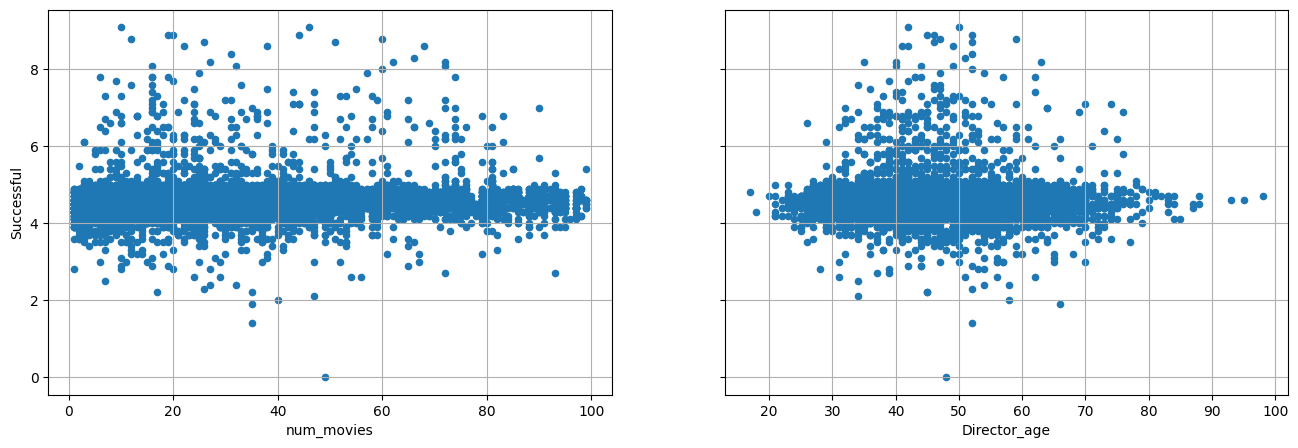

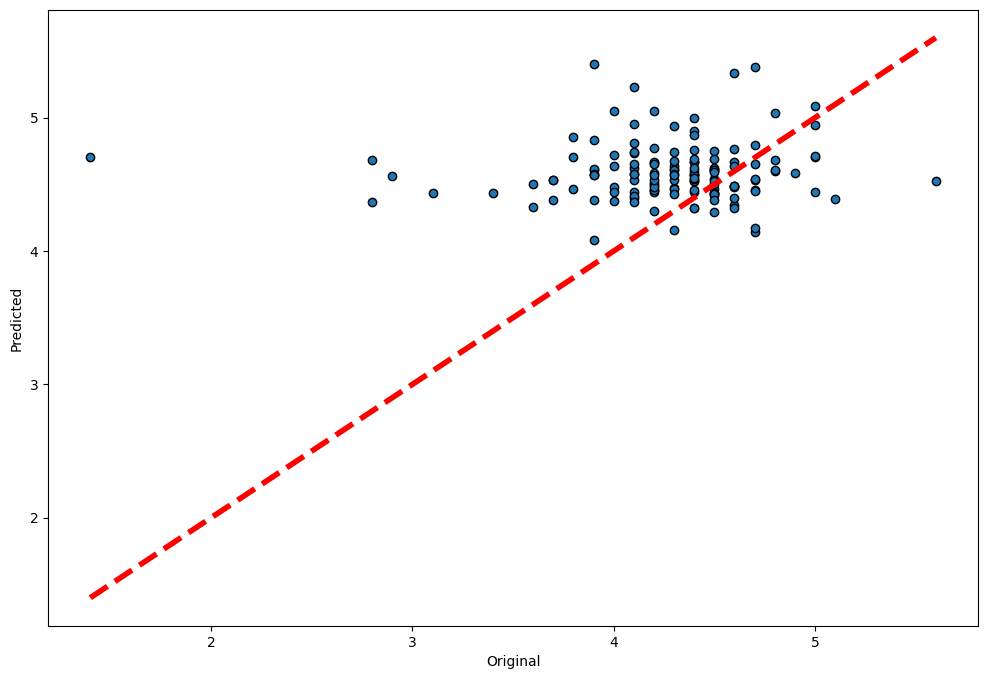

Mean Squared Error (MSE): 0.3673102083563303
Root Mean Squared Error (RMSE): 0.6060612249239595
Mean Absolute Error (MAE): 0.4279337421167402
R-squared (R²): -0.6073732412091504

Feature Importances:
num_movies: 0.5052764837069246
Director_age: 0.49472351629307537


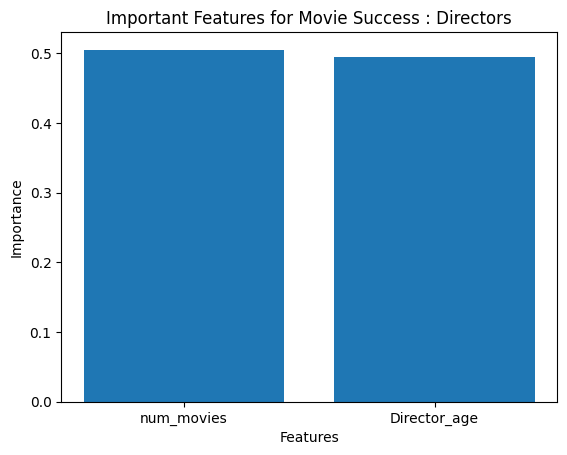

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df, X_train, X_test, y_train, y_test, and rf_model are already defined and available from the previous code

# 1. Visualize the Relationship Between Features and Response
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(16, 5))
df.plot(kind='scatter', x='num_movies', y='Successful', ax=axs[0], grid=True)
df.plot(kind='scatter', x='Director_age', y='Successful', ax=axs[1], grid=True)

# 2. Visualize Original vs Predicted Values
y_pred_rf = rf_model.predict(X_test)
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(y_test, y_pred_rf, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=4)
ax.set_xlabel('Original')
ax.set_ylabel('Predicted')
plt.show()

# 3. Evaluate the Random Forest model using R-squared and Mean Squared Error (MSE)
from sklearn.metrics import mean_absolute_error

# Assuming y_test (actual values) and y_pred_rf (predicted values by Random Forest) are available

# Compute Mean Squared Error (MSE)
mse_rf = mean_squared_error(y_test, y_pred_rf)

# Compute Root Mean Squared Error (RMSE)
rmse_rf = np.sqrt(mse_rf)

# Compute Mean Absolute Error (MAE)
mae_rf = mean_absolute_error(y_test, y_pred_rf)

# Compute R-squared (R²)
r2_rf = r2_score(y_test, y_pred_rf)

# Print the computed metrics
print(f"Mean Squared Error (MSE): {mse_rf}")
print(f"Root Mean Squared Error (RMSE): {rmse_rf}")
print(f"Mean Absolute Error (MAE): {mae_rf}")
print(f"R-squared (R²): {r2_rf}")

# Feature Importance
feature_importances = rf_model.feature_importances_

# Print Feature Importances
print("\nFeature Importances:")
for feature, importance in zip(features, feature_importances):
    print(f"{feature}: {importance}")



# 4. Visualize Feature Importance from Random Forest
feature_importances = rf_model.feature_importances_
features = X_train.columns
fig, ax = plt.subplots()
ax.bar(features, feature_importances)
ax.set_xlabel('Features')
ax.set_ylabel('Importance')
ax.set_title('Important Features for Movie Success : Directors')
plt.show()


